In [ ]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/archive (4)'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/archive (4)/ODIR-5K/ODIR-5K/Training Images/2870_left.jpg
/content/drive/MyDrive/archive (4)/ODIR-5K/ODIR-5K/Training Images/2902_left.jpg
/content/drive/MyDrive/archive (4)/ODIR-5K/ODIR-5K/Training Images/2876_right.jpg
/content/drive/MyDrive/archive (4)/ODIR-5K/ODIR-5K/Training Images/286_left.jpg
/content/drive/MyDrive/archive (4)/ODIR-5K/ODIR-5K/Training Images/2906_left.jpg
/content/drive/MyDrive/archive (4)/ODIR-5K/ODIR-5K/Training Images/2901_right.jpg
/content/drive/MyDrive/archive (4)/ODIR-5K/ODIR-5K/Training Images/2886_left.jpg
/content/drive/MyDrive/archive (4)/ODIR-5K/ODIR-5K/Training Images/2895_right.jpg
/content/drive/MyDrive/archive (4)/ODIR-5K/ODIR-5K/Training Images/2870_right.jpg
/content/drive/MyDrive/archive (4)/ODIR-5K/ODIR-5K/Training Images/2883_right.jpg
/content/drive/MyDrive/archive (4)/ODIR-5K/ODIR-5K/Training Images/28_right.jpg
/content/drive/MyDrive/archive (4)/ODIR-5K/ODIR-5K/Trai

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/archive (4)/full_df.csv")

In [ ]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [ ]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [ ]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [ ]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [ ]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [ ]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [ ]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)


In [ ]:
print(len(cataract),len(normal))

594 500


In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/content/drive/MyDrive/archive (4)/preprocessed_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue

        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [ ]:
dataset = create_dataset(cataract,1)

100%|██████████| 594/594 [03:08<00:00,  3.15it/s]


In [ ]:
len(dataset)

588

In [ ]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:06<00:00, 76.51it/s]


In [ ]:
len(dataset)

1088

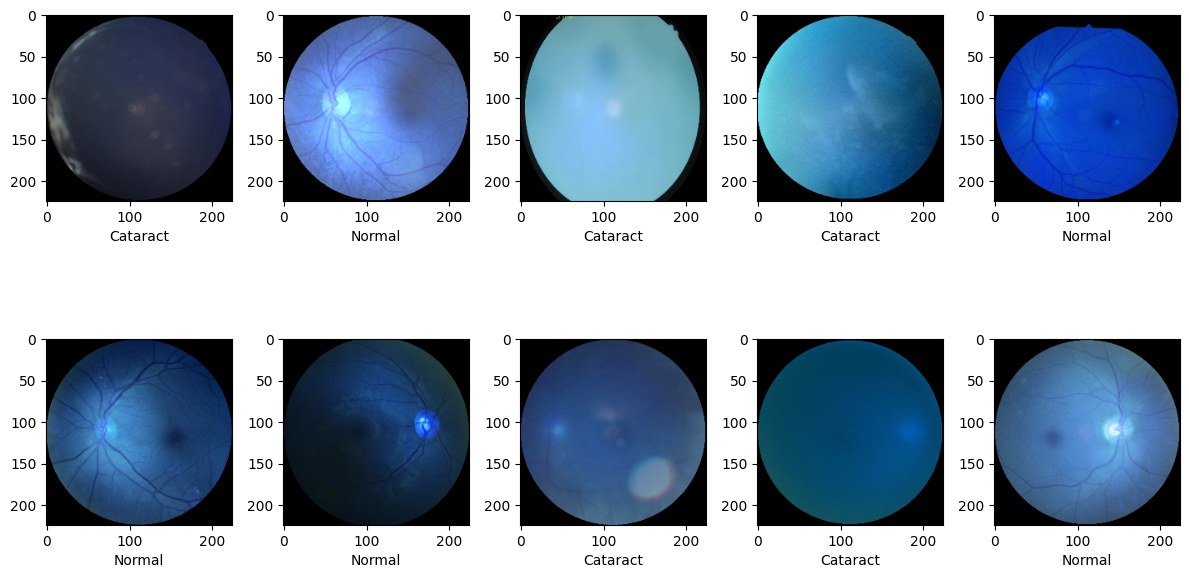

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [ ]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense, Conv2D, BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50

resnet = ResNet50(weights="imagenet", input_shape=(224, 224, 3), include_top=False)

for layer in resnet.layers:
    layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.layers import Dropout, Conv2D, BatchNormalization
x = Flatten() (resnet.output)
x = Dropout(0.5)(x) # Add a dropout layer with a rate of 0.5
x = BatchNormalization()(x) # Add a batch normalization layer
prediction = Dense(1, activation = 'relu')(x)
model = Model(inputs = resnet.input, outputs = prediction)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("resnet50.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [ ]:
history = model.fit(x_train,y_train,batch_size=16,epochs=30,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/30
48/48 [==============================] - ETA: 0s - loss: 1.6962 - accuracy: 0.8778

48/48 [==============================] - 224s 4s/step - loss: 1.6962 - accuracy: 0.8778 - val_loss: 4.8154 - val_accuracy: 0.6789
Epoch 2/30
48/48 [==============================] - ETA: 0s - loss: 1.9089 - accuracy: 0.8725

48/48 [==============================] - 208s 4s/step - loss: 1.9089 - accuracy: 0.8725 - val_loss: 1.8384 - val_accuracy: 0.8716
Epoch 3/30
48/48 [==============================] - ETA: 0s - loss: 1.4801 - accuracy: 0.9028

48/48 [==============================] - 208s 4s/step - loss: 1.4801 - accuracy: 0.9028 - val_loss: 1.3255 - val_accuracy: 0.9083
Epoch 4/30
48/48 [==============================] - ETA: 0s - loss: 1.2383 - accuracy: 0.9172

48/48 [==============================] - 210s 4s/step - loss: 1.2383 - accuracy: 0.9172 - val_loss: 1.5721 - val_accuracy: 0.8838
Epoch 5/30
48/48 [==============================] - ETA: 0s - loss: 1.2807 - accuracy: 0.9133

48/48 [==============================] - 210s 4s/step - loss: 1.2807 - accuracy: 0.9133 - val_loss: 1.6010 - val_accuracy: 0.8930
Epoch 6/30
48/48 [==============================] - ETA: 0s - loss: 1.3241 - accuracy: 0.9093

48/48 [==============================] - 183s 4s/step - loss: 1.3241 - accuracy: 0.9093 - val_loss: 2.2575 - val_accuracy: 0.8532
Epoch 7/30
48/48 [==============================] - ETA: 0s - loss: 2.2119 - accuracy: 0.8515

48/48 [==============================] - 211s 4s/step - loss: 2.2119 - accuracy: 0.8515 - val_loss: 1.8316 - val_accuracy: 0.8777
Epoch 8/30
48/48 [==============================] - ETA: 0s - loss: 2.2370 - accuracy: 0.8489

48/48 [==============================] - 187s 4s/step - loss: 2.2370 - accuracy: 0.8489 - val_loss: 2.5433 - val_accuracy: 0.8349
Epoch 9/30
48/48 [==============================] - ETA: 0s - loss: 2.0910 - accuracy: 0.8607

48/48 [==============================] - 184s 4s/step - loss: 2.0910 - accuracy: 0.8607 - val_loss: 1.9340 - val_accuracy: 0.8685
Epoch 10/30
48/48 [==============================] - ETA: 0s - loss: 1.9019 - accuracy: 0.8752

48/48 [==============================] - 209s 4s/step - loss: 1.9019 - accuracy: 0.8752 - val_loss: 1.8829 - val_accuracy: 0.8777
Epoch 11/30
48/48 [==============================] - ETA: 0s - loss: 1.5976 - accuracy: 0.8949

48/48 [==============================] - 210s 4s/step - loss: 1.5976 - accuracy: 0.8949 - val_loss: 1.5536 - val_accuracy: 0.8960
Epoch 12/30
48/48 [==============================] - ETA: 0s - loss: 1.3634 - accuracy: 0.9067

48/48 [==============================] - 209s 4s/step - loss: 1.3634 - accuracy: 0.9067 - val_loss: 1.5006 - val_accuracy: 0.9021
Epoch 13/30
48/48 [==============================] - ETA: 0s - loss: 1.5964 - accuracy: 0.8909

48/48 [==============================] - 209s 4s/step - loss: 1.5964 - accuracy: 0.8909 - val_loss: 1.6424 - val_accuracy: 0.8930
Epoch 14/30
48/48 [==============================] - ETA: 0s - loss: 1.3807 - accuracy: 0.9080

48/48 [==============================] - 209s 4s/step - loss: 1.3807 - accuracy: 0.9080 - val_loss: 1.9853 - val_accuracy: 0.8685
Epoch 15/30
48/48 [==============================] - ETA: 0s - loss: 1.8501 - accuracy: 0.8765

48/48 [==============================] - 208s 4s/step - loss: 1.8501 - accuracy: 0.8765 - val_loss: 2.3153 - val_accuracy: 0.8440
Epoch 16/30
48/48 [==============================] - ETA: 0s - loss: 1.5299 - accuracy: 0.8936

48/48 [==============================] - 182s 4s/step - loss: 1.5299 - accuracy: 0.8936 - val_loss: 2.0246 - val_accuracy: 0.8685
Epoch 17/30
48/48 [==============================] - ETA: 0s - loss: 1.3379 - accuracy: 0.9120

48/48 [==============================] - 207s 4s/step - loss: 1.3379 - accuracy: 0.9120 - val_loss: 1.9773 - val_accuracy: 0.8716
Epoch 18/30
48/48 [==============================] - ETA: 0s - loss: 1.5814 - accuracy: 0.8962

48/48 [==============================] - 208s 4s/step - loss: 1.5814 - accuracy: 0.8962 - val_loss: 1.9308 - val_accuracy: 0.8746
Epoch 19/30
48/48 [==============================] - ETA: 0s - loss: 1.1770 - accuracy: 0.9198

48/48 [==============================] - 208s 4s/step - loss: 1.1770 - accuracy: 0.9198 - val_loss: 1.6470 - val_accuracy: 0.8930
Epoch 20/30
48/48 [==============================] - ETA: 0s - loss: 1.1538 - accuracy: 0.9251

48/48 [==============================] - 210s 4s/step - loss: 1.1538 - accuracy: 0.9251 - val_loss: 1.6467 - val_accuracy: 0.8930
Epoch 21/30
48/48 [==============================] - ETA: 0s - loss: 1.1123 - accuracy: 0.9264

48/48 [==============================] - 209s 4s/step - loss: 1.1123 - accuracy: 0.9264 - val_loss: 1.6474 - val_accuracy: 0.8930
Epoch 22/30
48/48 [==============================] - ETA: 0s - loss: 1.2797 - accuracy: 0.9133

48/48 [==============================] - 182s 4s/step - loss: 1.2797 - accuracy: 0.9133 - val_loss: 1.6102 - val_accuracy: 0.8899
Epoch 23/30
48/48 [==============================] - ETA: 0s - loss: 1.3556 - accuracy: 0.9120

48/48 [==============================] - 179s 4s/step - loss: 1.3556 - accuracy: 0.9120 - val_loss: 1.6942 - val_accuracy: 0.8899
Epoch 24/30
48/48 [==============================] - ETA: 0s - loss: 1.2365 - accuracy: 0.9185

48/48 [==============================] - 207s 4s/step - loss: 1.2365 - accuracy: 0.9185 - val_loss: 1.5995 - val_accuracy: 0.8960
Epoch 25/30
48/48 [==============================] - ETA: 0s - loss: 1.1338 - accuracy: 0.9264

48/48 [==============================] - 208s 4s/step - loss: 1.1338 - accuracy: 0.9264 - val_loss: 1.5995 - val_accuracy: 0.8960
Epoch 26/30
48/48 [==============================] - ETA: 0s - loss: 1.1931 - accuracy: 0.9225

48/48 [==============================] - 207s 4s/step - loss: 1.1931 - accuracy: 0.9225 - val_loss: 1.5996 - val_accuracy: 0.8960
Epoch 27/30
48/48 [==============================] - ETA: 0s - loss: 1.0768 - accuracy: 0.9277

48/48 [==============================] - 208s 4s/step - loss: 1.0768 - accuracy: 0.9277 - val_loss: 1.5052 - val_accuracy: 0.9021
Epoch 28/30
48/48 [==============================] - ETA: 0s - loss: 1.0520 - accuracy: 0.9304

48/48 [==============================] - 209s 4s/step - loss: 1.0520 - accuracy: 0.9304 - val_loss: 1.5046 - val_accuracy: 0.9021
Epoch 29/30
48/48 [==============================] - ETA: 0s - loss: 0.8128 - accuracy: 0.9448

48/48 [==============================] - 206s 4s/step - loss: 0.8128 - accuracy: 0.9448 - val_loss: 1.3639 - val_accuracy: 0.9113
Epoch 30/30
48/48 [==============================] - ETA: 0s - loss: 1.1357 - accuracy: 0.9251

48/48 [==============================] - 208s 4s/step - loss: 1.1357 - accuracy: 0.9251 - val_loss: 1.1266 - val_accuracy: 0.9266


In [ ]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

11/11 [==============================] - 60s 5s/step - loss: 1.1266 - accuracy: 0.9266
loss: 1.1265970468521118
Accuracy: 0.9266055226325989


In [ ]:
!pip install scikit-learn

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [ ]:
# Obtain the predicted probability values for the test data
y_pred = model.predict(x_test)

# Convert the predicted probability values to class labels
y_pred = (y_pred > 0.5).astype(int)

11/11 [==============================] - 87s 6s/step


In [ ]:
accuracy_score(y_test,y_pred)

0.926605504587156

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       156
           1       0.90      0.96      0.93       171

    accuracy                           0.93       327
   macro avg       0.93      0.92      0.93       327
weighted avg       0.93      0.93      0.93       327



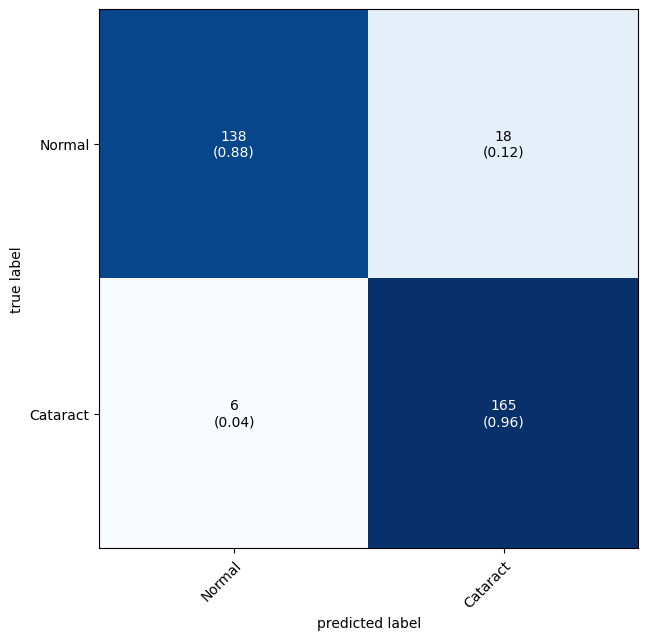

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
                      show_normed = True);

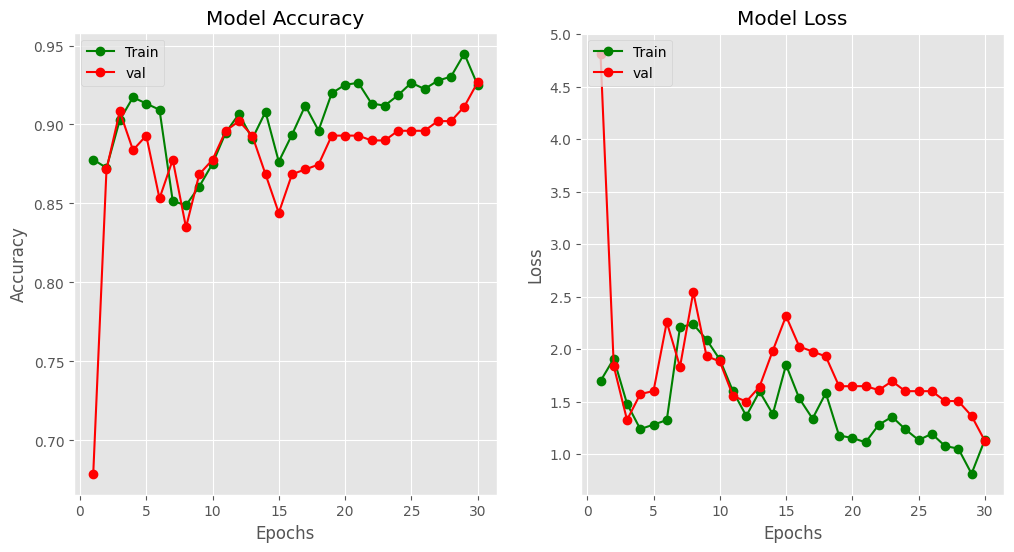

In [ ]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,31)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

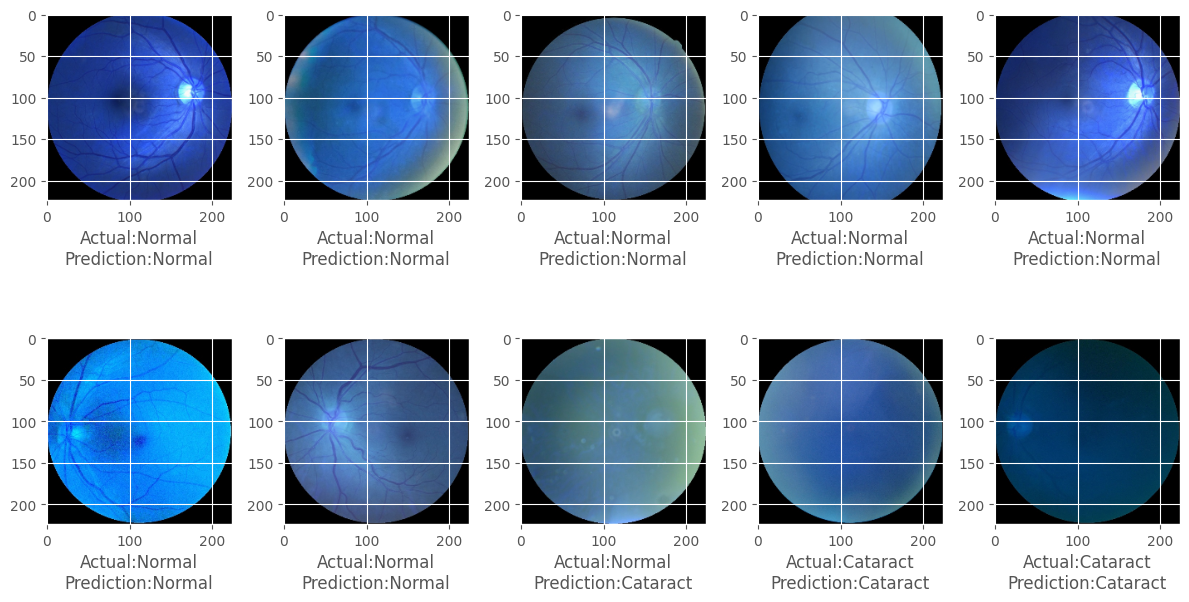

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]

    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"

    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()